# **CIS 5450 Final Project - Clash of Clans Clan War Performance Prediction**
*Wesley Liu, David Lee, Sam Park*

# Part 1: Introduction

Our final project aims to better understand the popular mobile game, *Clash of Clans*. Specifically, we want to analyze the factors that influence a clan's war win rate. Our Kaggle dataset contains information from over 3.5 million different clans, such as their clan description, location, level, war wins, and more. However, what makes this interesting is that simply having higher level reqiurements for members may not have a significant impact on clan war win percentage, since clans are typically matched with other clans of similar levels. Thus, we will analyze the true significance of factors like these and create a regression model to predict clan war win percentage.

# Part 2: Data Loading & Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import re
import gc

## 2.1 Loading Kaggle Data

The COC dataset can be downloading using Kaggle's API key. To download the dataset, go to https://www.kaggle.com/, create an account, create an api key, and then save the api key's json file to Google Drive.

In [2]:
# Mount drive to get kaggle API key
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Create the kaggle directory
!mkdir ~/.kaggle

In [4]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [5]:
# Download COC dataset
!!kaggle datasets download -d asaniczka/clash-of-clans-clans-dataset-2023-3-5m-clans

['Dataset URL: https://www.kaggle.com/datasets/asaniczka/clash-of-clans-clans-dataset-2023-3-5m-clans',
 'License(s): ODC Attribution License (ODC-By)',
 'Downloading clash-of-clans-clans-dataset-2023-3-5m-clans.zip to /content',
 '',
 '  0% 0.00/335M [00:00<?, ?B/s]',
 '  2% 7.00M/335M [00:00<00:04, 71.8MB/s]',
 '  5% 17.0M/335M [00:00<00:04, 70.5MB/s]',
 ' 10% 33.0M/335M [00:00<00:02, 106MB/s] ',
 ' 13% 44.0M/335M [00:00<00:03, 101MB/s]',
 ' 17% 58.0M/335M [00:00<00:02, 114MB/s]',
 ' 21% 70.0M/335M [00:00<00:03, 89.0MB/s]',
 ' 27% 89.0M/335M [00:01<00:03, 79.1MB/s]',
 ' 34% 113M/335M [00:01<00:02, 93.9MB/s] ',
 ' 39% 129M/335M [00:01<00:02, 95.7MB/s]',
 ' 44% 146M/335M [00:01<00:01, 110MB/s] ',
 ' 48% 161M/335M [00:01<00:01, 116MB/s]',
 ' 53% 176M/335M [00:01<00:01, 125MB/s]',
 ' 58% 193M/335M [00:01<00:01, 137MB/s]',
 ' 62% 209M/335M [00:01<00:00, 145MB/s]',
 ' 67% 224M/335M [00:02<00:00, 148MB/s]',
 ' 71% 239M/335M [00:02<00:00, 118MB/s]',
 ' 76% 255M/335M [00:02<00:00, 130MB/s]',


In [6]:
# Unzip folder in Colab content folder
!unzip /content/clash-of-clans-clans-dataset-2023-3-5m-clans.zip

Archive:  /content/clash-of-clans-clans-dataset-2023-3-5m-clans.zip
  inflating: coc_clans_dataset.csv   


In [7]:
# Load the csv into a pandas dataframe
coc_df = pd.read_csv('/content/coc_clans_dataset.csv')

## 2.2 Inspecting Data

Let's do a quick inspection of our data using pandas.

In [8]:
# Inspect first 5 rows
coc_df.head()

,clan_tag,clan_name,clan_type,clan_description,clan_location,isFamilyFriendly,clan_badge_url,clan_level,clan_points,clan_builder_base_points,...,clan_war_league,num_members,required_builder_base_trophies,required_versus_trophies,required_townhall_level,clan_capital_hall_level,clan_capital_points,capital_league,mean_member_level,mean_member_trophies
0,#UQVQRJQ0,KOJIS' CLAN,closed,STRATEGY IS MUST...RESPECT THE OTHERS...FORGIV...,International,True,https://api-assets.clashofclans.com/badges/200...,6,6887,5213,...,Unranked,11,1000,1000,1,1,0,Unranked,83,1254
1,#2QC9Y0CQU,uye,open,NaN,Indonesia,True,https://api-assets.clashofclans.com/badges/200...,1,876,1019,...,Unranked,1,0,0,1,0,0,Unranked,90,1752
2,#202CJRP2U,Uprising rivals,open,💥official uprising rivals clan💥we bring 10% lu...,Indonesia,True,https://api-assets.clashofclans.com/badges/200...,1,732,670,...,Unranked,2,0,0,1,0,0,Unranked,30,733
3,#2Y89RRGLY,2inchersonly,open,"Whom is not packing the meat, Shall be packing...",International,True,https://api-assets.clashofclans.com/badges/200...,2,1156,457,...,Bronze League I,2,0,0,1,1,0,Unranked,61,1156
4,#99PU9QPY,aymil,open,regla1=no empezar la guerra sin mi permiso reg...,International,True,https://api-assets.clashofclans.com/badges/200...,2,674,399,...,Unranked,2,0,0,1,0,0,Unranked,23,674


In [9]:
# Understand the shape of our dataset
print(f'Clans: {coc_df.shape[0]}')
print(f'Features: {coc_df.shape[1]}')

Clans: 3559743
Features: 27


In [10]:
# See the types of our features as well as the null count
coc_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559743 entries, 0 to 3559742
Data columns (total 27 columns):
 #   Column                          Non-Null Count    Dtype 
---  ------                          --------------    ----- 
 0   clan_tag                        3559743 non-null  object
 1   clan_name                       3559681 non-null  object
 2   clan_type                       3559743 non-null  object
 3   clan_description                2208378 non-null  object
 4   clan_location                   2108071 non-null  object
 5   isFamilyFriendly                3559743 non-null  bool  
 6   clan_badge_url                  3559743 non-null  object
 7   clan_level                      3559743 non-null  int64 
 8   clan_points                     3559743 non-null  int64 
 9   clan_builder_base_points        3559743 non-null  int64 
 10  clan_versus_points              3559743 non-null  int64 
 11  required_trophies               3559743 non-null  int64 
 12  war_frequency 

Observations:

The only columns that have null values is clan_name, clan_description, and clan_location. The latter two have null as the majority of values, so we will likely need to handle them later somehow.



In [11]:
# View some metrics about our numerical columns
coc_df.describe(include='all')

,clan_tag,clan_name,clan_type,clan_description,clan_location,isFamilyFriendly,clan_badge_url,clan_level,clan_points,clan_builder_base_points,...,clan_war_league,num_members,required_builder_base_trophies,required_versus_trophies,required_townhall_level,clan_capital_hall_level,clan_capital_points,capital_league,mean_member_level,mean_member_trophies
count,3559743,3559681,3559743,2208378,2108071,3559743,3559743,3.559743e+06,3.559743e+06,3.559743e+06,...,3559743,3.559743e+06,3.559743e+06,3.559743e+06,3.559743e+06,3.559743e+06,3.559743e+06,3559743,3.559743e+06,3.559743e+06
unique,3559743,2689319,3,1971613,255,2,23268,NaN,NaN,NaN,...,19,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN
top,#UQVQRJQ0,111,open,hi,International,False,https://api-assets.clashofclans.com/badges/200...,NaN,NaN,NaN,...,Unranked,NaN,NaN,NaN,NaN,NaN,NaN,Unranked,NaN,NaN
freq,1,611,2569771,3214,504866,2385364,442252,NaN,NaN,NaN,...,3036158,NaN,NaN,NaN,NaN,NaN,NaN,3386262,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.349883e+00,2.576062e+03,2.562565e+03,...,NaN,4.758147e+00,2.305894e+02,2.305894e+02,2.195218e+00,5.651079e-01,6.836864e+01,NaN,4.884267e+01,8.971466e+02
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.298436e+00,5.863921e+03,5.866313e+03,...,NaN,8.287075e+00,7.362564e+02,7.362564e+02,2.733998e+00,1.607310e+00,3.652351e+02,NaN,3.868762e+01,5.874875e+02
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,0.000000e+00,0.000000e+00,...,NaN,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,3.520000e+02,1.000000e+02,...,NaN,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN,1.800000e+01,4.940000e+02
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,6.930000e+02,6.470000e+02,...,NaN,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN,3.800000e+01,7.900000e+02
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+00,1.801000e+03,1.867000e+03,...,NaN,4.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN,7.100000e+01,1.155000e+03


Some initial observations:

*   Most features appear to be heavily skewed or have outliers, such as clan_level, required_trophies, any of the metrics with war wins/losses/streaks, clan_capital_hall_level, etc. This can be seen through the difference between the 75th quartile and the max, where there is usually a large jump between the two. This is likely because the vast majority of players and clans in COC tend to be more on the casual side, and thus may not devote that much time or effort towards advancing their clan levels and related metrics. However, these outliers are very likely not measurement errors and are legitimate entries, since a very small amount of clans are simply much more competitive than the average, casual clan. Removing these would cause an unnecessary loss of information.
*   Many clans seem to not participate in wars, and thus must be removed from the dataset in order to actually train the model. The reason for this is likely the same as above.



Now, we will compute the clan war win percentage as a column in our dataframe. We cannot simply use `war_wins` as the metric we are predicting in our model, since the number of wars a clan participates in will likely have a much larger impact on the metric compared to any other feature.

In [12]:
# win_percentage will be our target metric
coc_df['win_percentage'] = 100 * coc_df['war_wins'] / (coc_df['war_wins'] + coc_df['war_ties'] + coc_df['war_losses'])
coc_df.head()

,clan_tag,clan_name,clan_type,clan_description,clan_location,isFamilyFriendly,clan_badge_url,clan_level,clan_points,clan_builder_base_points,...,num_members,required_builder_base_trophies,required_versus_trophies,required_townhall_level,clan_capital_hall_level,clan_capital_points,capital_league,mean_member_level,mean_member_trophies,win_percentage
0,#UQVQRJQ0,KOJIS' CLAN,closed,STRATEGY IS MUST...RESPECT THE OTHERS...FORGIV...,International,True,https://api-assets.clashofclans.com/badges/200...,6,6887,5213,...,11,1000,1000,1,1,0,Unranked,83,1254,75.000000
1,#2QC9Y0CQU,uye,open,NaN,Indonesia,True,https://api-assets.clashofclans.com/badges/200...,1,876,1019,...,1,0,0,1,0,0,Unranked,90,1752,NaN
2,#202CJRP2U,Uprising rivals,open,💥official uprising rivals clan💥we bring 10% lu...,Indonesia,True,https://api-assets.clashofclans.com/badges/200...,1,732,670,...,2,0,0,1,0,0,Unranked,30,733,100.000000
3,#2Y89RRGLY,2inchersonly,open,"Whom is not packing the meat, Shall be packing...",International,True,https://api-assets.clashofclans.com/badges/200...,2,1156,457,...,2,0,0,1,1,0,Unranked,61,1156,38.888889
4,#99PU9QPY,aymil,open,regla1=no empezar la guerra sin mi permiso reg...,International,True,https://api-assets.clashofclans.com/badges/200...,2,674,399,...,2,0,0,1,0,0,Unranked,23,674,21.428571


## 2.3 Dropping Rows and Columns

First, we will drop rows corresponding to clans that have participated in less than 20 wars total. Clearly, we should not include clans that have participated in 0 wars because their clan war win percentage is undefined. However, we also choose to exclude clans with less than 20 wars because of the small sample size of wars that they have. For example, a clan that is bad at wars could have participated in just one and won it by chance, resulting in a win percentage of 100%. We do not want small sample sizes of wars to impact our model prediction.

In [13]:
# Drop rows corresponding to clans with < 20 wars
low_participation_df = coc_df[coc_df['war_wins'] + coc_df['war_ties'] + coc_df['war_losses'] < 20]
cleaned_coc_df = coc_df.drop(low_participation_df.index, axis=0)

print(f'Dropped {len(low_participation_df)} rows.')
print(f'{len(cleaned_coc_df)} rows remaining.')

Dropped 2839972 rows.
719771 rows remaining.


Dropping `clan_tag`, `clan_badge_url`: Both of these features likely have no clear relationship with the win percentage of a clan. `clan_tag` is the unique identifier for each clan, and `clan_badge_url` provides the url to the badge image that a clan uses, which likely has a minimal impact on win percentage compared to the other features.


In [14]:
# Drop unrelated columns
cleaned_coc_df = cleaned_coc_df.drop(['clan_tag', 'clan_badge_url'], axis = 1)

Dropping `clan_level`, `war_win_streak`, `war_wins`, `war_ties`, `war_losses`, `clan_war_league`: All of these features will result in data leakage if kept in the dataset. `clan_level` and `clan_war_league` increases when clans win wars. `war_win_streak`, `war_wins`, `war_ties`, and `war_losses` all clearly leak information about the win percentage. Thus, we must remove these from the dataset to prevent data leakage.

On the other hand, we keep `clan_points` because this is solely calculated from the trophies of the members, and does not have anything to do with war performance. Any features that have to do with 'capital' are also unrelated to war, but rather a different event called raids. Finally, `war_frequency` is also kept because this is a public description that is set by the clan itself and is not determined by metrics.

In [15]:
# Drop columns that will result in data leakage
cleaned_coc_df = cleaned_coc_df.drop(['clan_level', 'war_win_streak',
                                      'war_wins', 'war_ties',
                                      'war_losses', 'clan_war_league'],
                                     axis = 1)

We will quickly inspect our cleaned dataset just to make sure that our `win_percentage` does not have any faulty or missing values (ex. NaN, percentages above 100%).

In [16]:
cleaned_coc_df.describe(include='all')

,clan_name,clan_type,clan_description,clan_location,isFamilyFriendly,clan_points,clan_builder_base_points,clan_versus_points,required_trophies,war_frequency,num_members,required_builder_base_trophies,required_versus_trophies,required_townhall_level,clan_capital_hall_level,clan_capital_points,capital_league,mean_member_level,mean_member_trophies,win_percentage
count,719765,719771,625368,662041,719771,719771.000000,719771.000000,719771.000000,719771.000000,719771,719771.000000,719771.000000,719771.000000,719771.000000,719771.000000,719771.000000,719771,719771.000000,719771.000000,719771.000000
unique,633514,3,605743,255,2,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,NaN
top,300,open,welcome,International,False,NaN,NaN,NaN,NaN,always,NaN,NaN,NaN,NaN,NaN,NaN,Unranked,NaN,NaN,NaN
freq,105,377159,535,152446,469710,NaN,NaN,NaN,NaN,495001,NaN,NaN,NaN,NaN,NaN,NaN,562540,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,8554.787766,8647.690739,8647.690739,853.369148,NaN,13.128535,478.332957,478.332957,3.988159,2.311238,324.440300,NaN,82.604063,1412.648110,59.930098
std,NaN,NaN,NaN,NaN,NaN,10638.939823,10436.734936,10436.734936,1121.409934,NaN,14.175979,987.392042,987.392042,4.139651,2.817387,753.835003,NaN,44.170397,755.450002,25.256431
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,1380.000000,1140.000000,1140.000000,0.000000,NaN,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,NaN,50.000000,915.000000,42.028986
50%,NaN,NaN,NaN,NaN,NaN,3923.000000,4048.000000,4048.000000,400.000000,NaN,7.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,78.000000,1238.000000,54.409006
75%,NaN,NaN,NaN,NaN,NaN,10990.000000,12440.000000,12440.000000,1200.000000,NaN,19.000000,600.000000,600.000000,7.000000,3.000000,36.000000,NaN,108.000000,1724.000000,74.647887


One interesting we note is that after dropping the clans with < 20 wars participated in, the mean win_percentage goes from 50% to almost 60%. It seems that the clans with less wars participated in usually did worse.

In [17]:
print(f"win_percentage has NaN values: {cleaned_coc_df['win_percentage'].isna().any()}")

win_percentage has NaN values: False


Delete coc_df to save some memory.

In [18]:
del coc_df

# Call garbage collector explicitly
gc.collect()

31

# Part 3: Exploratory Data Analysis (EDA)

## 3.1 Feature Distributions

To plot distributions, we will use the following plotting function:

In [19]:
def plot_dist(data, col, cat=True):
  plt.figure(figsize=(6,4))

  if cat:
    # If there are a lot of categorical columns, group up the low-frequency ones
    if data[col].nunique() > 30:
      total_count = len(data)

      # 3% threshold
      threshold = total_count * 0.03

      # Get low-frequency values
      value_counts = data[col].value_counts()
      grouped_data = data[col].copy().astype('object') # Cast to object in case it's categorical

      # Group values appearing < 3% of the time into 'Other'
      for value, count in value_counts.items():
          if count < threshold:
              grouped_data[grouped_data == value] = 'Other'
      sns.countplot(x=grouped_data)
    else:
      sns.countplot(data=data, x=col)
    plt.xticks(rotation=90)

  # If it's numerical, just do a histplot
  else:
    sns.histplot(data=data, x=col, kde=True, stat='count')

  plt.title(f'Distribution of {col}')
  plt.show()

### 3.1.1 Numerical Distributions

First, we will plot the distributions of some numerical columns.

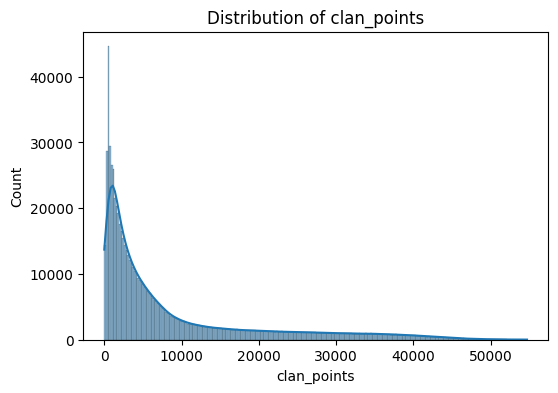

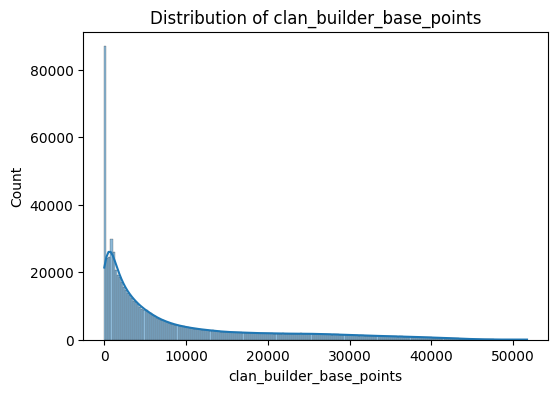

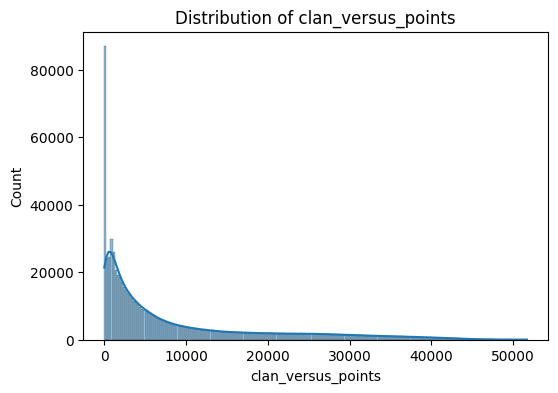

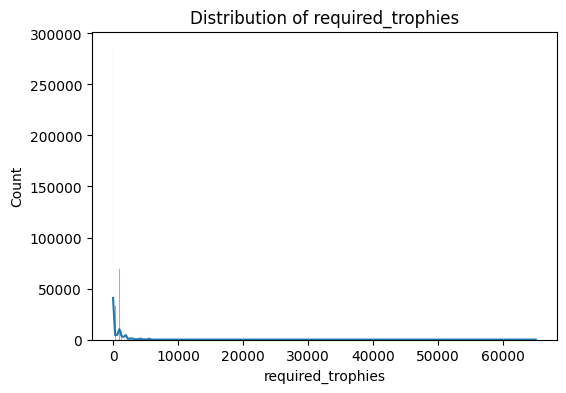

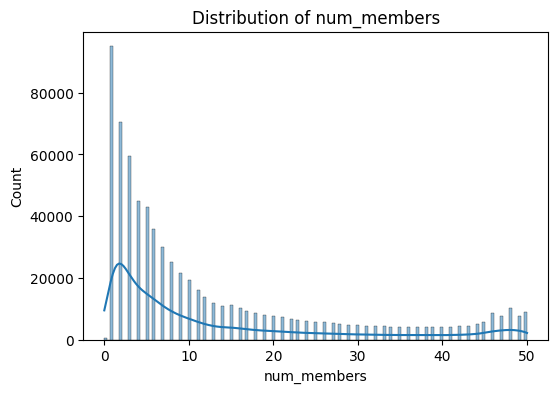

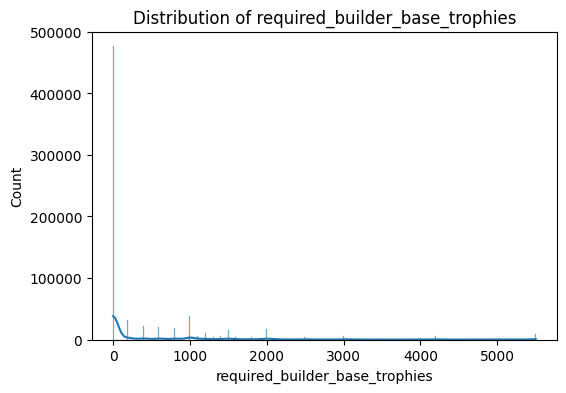

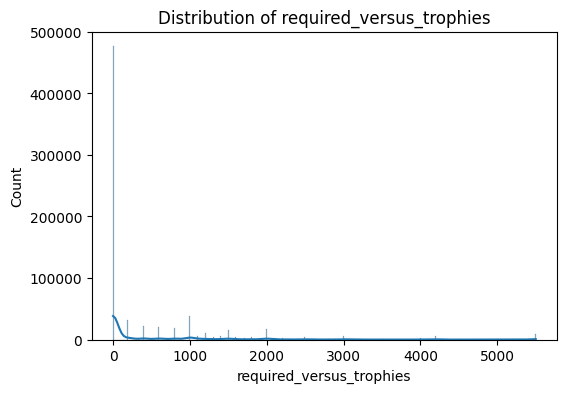

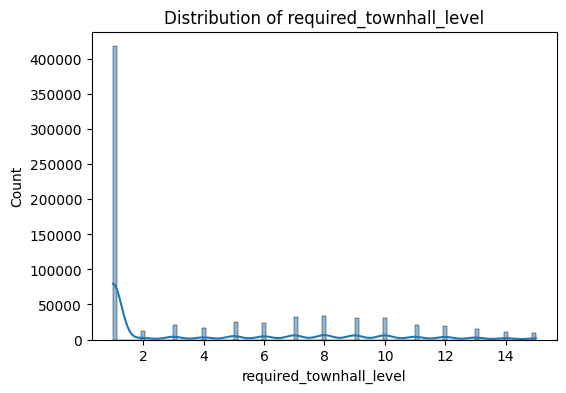

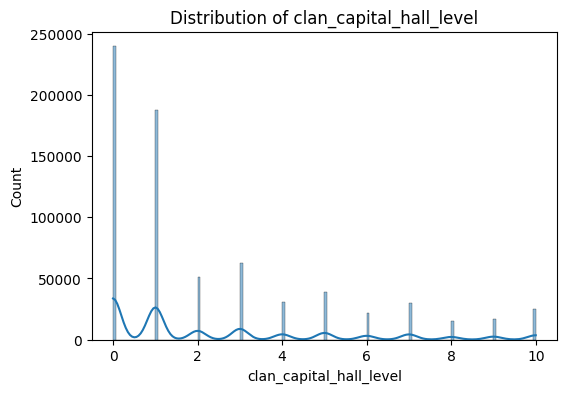

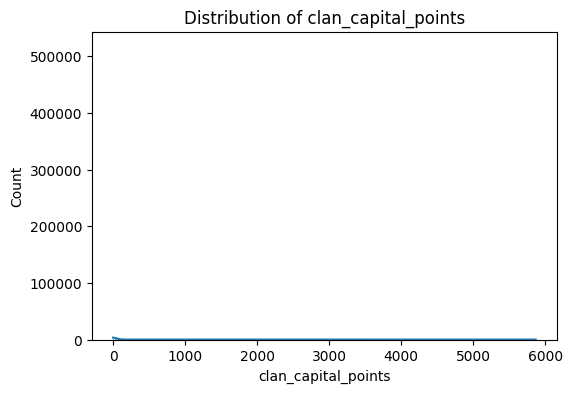

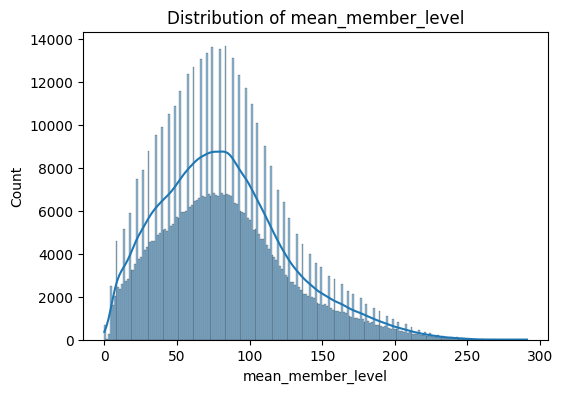

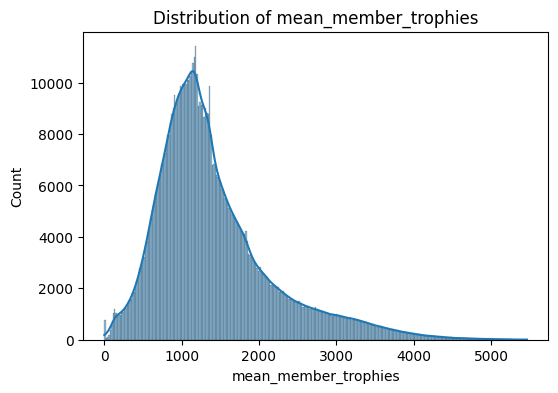

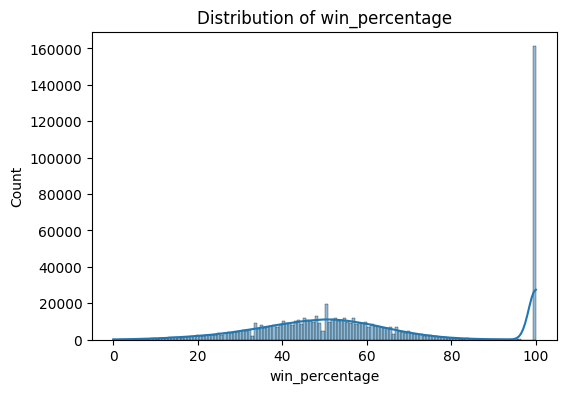

In [20]:
numerical_cols = ['clan_points', 'clan_builder_base_points', 'clan_versus_points',
                 'required_trophies', 'num_members', 'required_builder_base_trophies',
                 'required_versus_trophies', 'required_townhall_level',
                 'clan_capital_hall_level', 'clan_capital_points',
                 'mean_member_level', 'mean_member_trophies', 'win_percentage']

# Plot histplots using Seaborn
for col in numerical_cols:
  plot_dist(cleaned_coc_df, col, cat=False)

Observations:


*   Every single distribution is right skewed, except `win_percentage`. This is likely because most of the players in clash of clans are either casual players or users that no longer play the game. Additionally, many of the default settings for these features when creating a clan are likely set to 0, resulting in higher counts for those values.
*   Interestingly, `win_percentage` looks to be a mostly normal distribution, but there is a large jump in the number of clans that have a 100% win rate. This could be because some very competitive clans take war very seriously and plan out strategies that allow them to consistently win. However, the amount of clans that have a 100% win rate is much higher than expected.
*   While there are clearly some outliers, we choose not to remove them because these are likely legitimate samples from extremely competitive clans. Values like these may help in separating low-winrate clans from high-winrate clans.




Since there oddly seems to be a large number of clans that have a 100% win rate, we will plot the distributions of the features for only clans with this perfect win rate, in order to see if there are any unique attributes that may cause a clan to have such a high win rate. Since we dropped clans with less than 20 wars participated in, these win rates are likely not due to pure chance.

In [21]:
# Filter just the perfect winrate clans
perfect_win_df = cleaned_coc_df[cleaned_coc_df['win_percentage'] == 100]

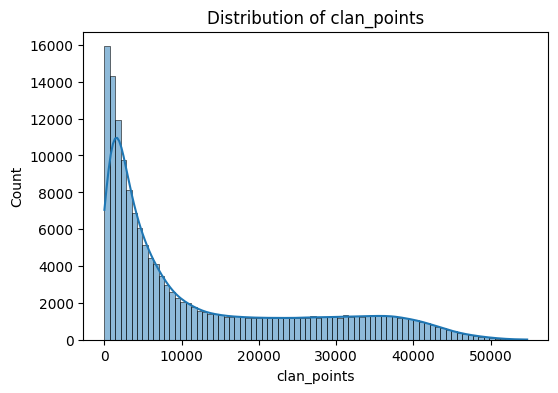

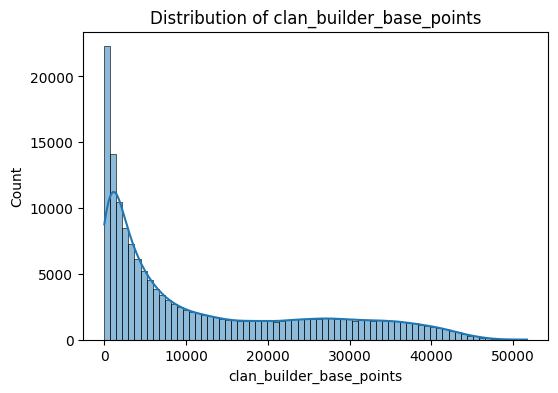

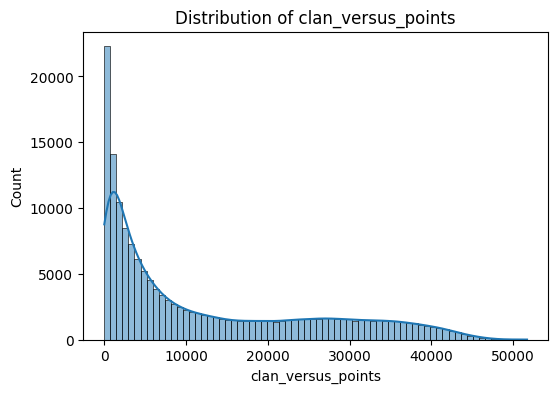

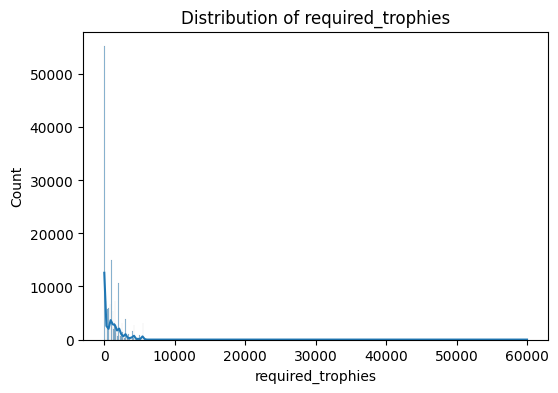

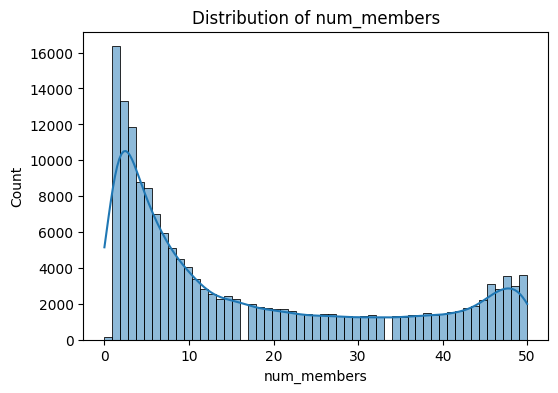

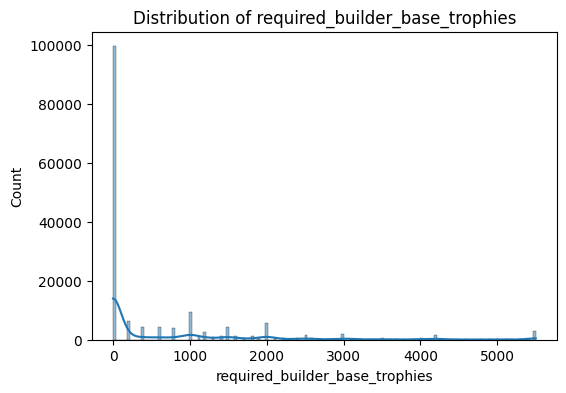

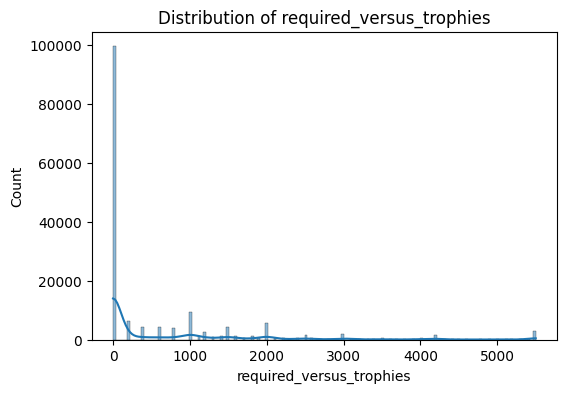

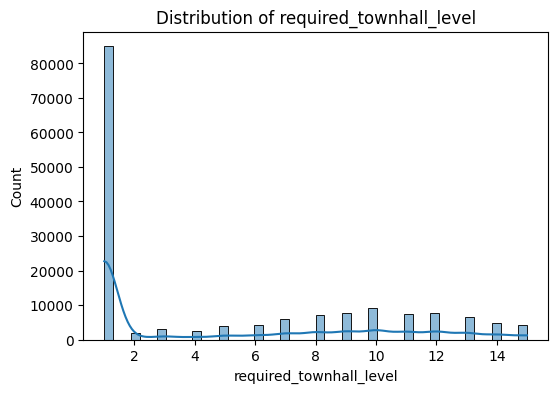

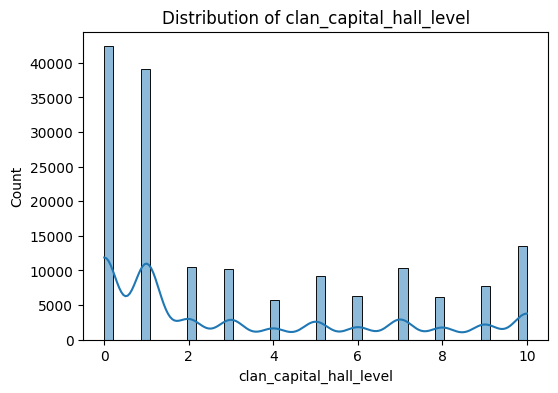

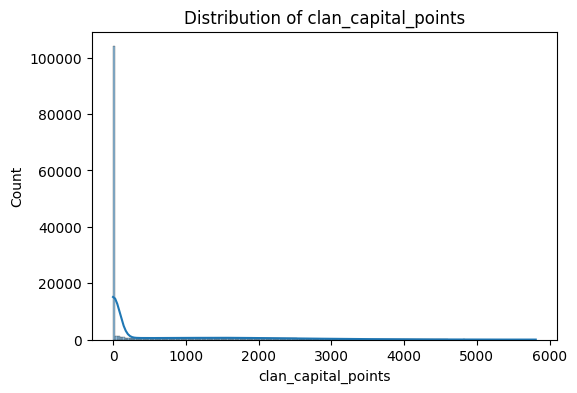

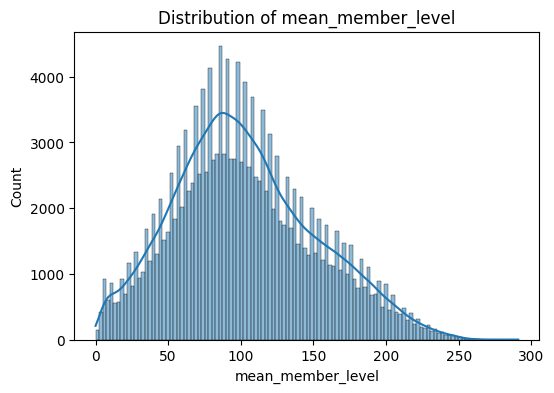

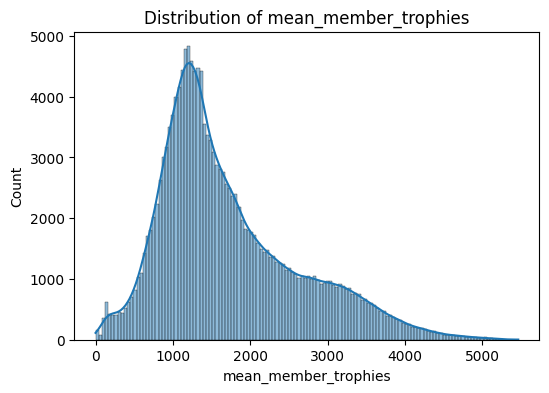

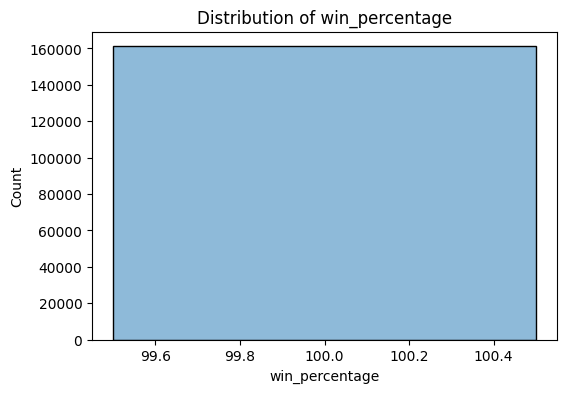

In [22]:
# Plot countplots using Seaborn
for col in numerical_cols:
  plot_dist(perfect_win_df, col, cat=False)

Observations:
*   The distribution of the features from perfect winrate clans is extremely similar to that of non-perfect winrate clans. There is no clear explanation from the numerical features why some clans have a perfect winrate and other do not.

### 3.1.2 Categorical Distributions

Before we plot the distribution of the categorical columns, we will first convert their type to categorical and also impose ordering as necessary.

In [23]:
# Convert clan_type to categorical type but without ordering
cleaned_coc_df['clan_type'] = cleaned_coc_df['clan_type'].astype(
    pd.CategoricalDtype(ordered=False))

# Assign ordering to war_frequency categories
cleaned_coc_df['war_frequency'] = cleaned_coc_df['war_frequency'].astype(
    pd.CategoricalDtype(
      ['unknown', 'never', 'lessThanOncePerWeek',
      'oncePerWeek', 'moreThanOncePerWeek', 'always'],
    ordered=True))

# Assign ordering to capital_league categories
cleaned_coc_df['capital_league'] = cleaned_coc_df['capital_league'].astype(
    pd.CategoricalDtype(
      ['Unranked', 'Bronze League III', 'Bronze League II', 'Bronze League I',
       'Silver League III', 'Silver League II', 'Silver League I',
       'Gold League III', 'Gold League II', 'Gold League I',
       'Crystal League III', 'Crystal League II', 'Crystal League I',
       'Master League III', 'Master League II', 'Master League I',
       'Champion League III', 'Champion League II', 'Champion League I',
       'Titan League III', 'Titan League II', 'Titan League I',
       'Legend League III', 'Legend League II', 'Legend League I'],
    ordered=True))

Next, we will plot the distribution of a few categorical columns.

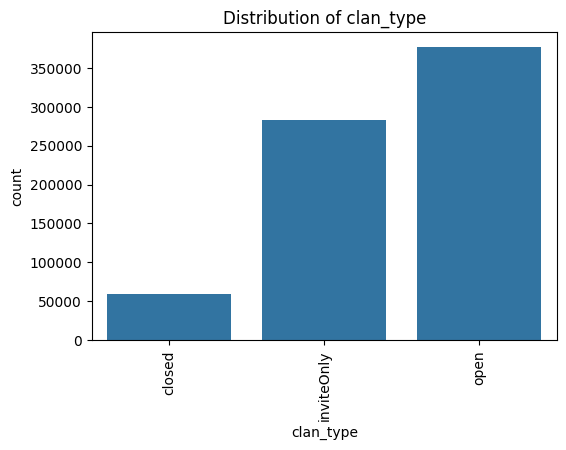

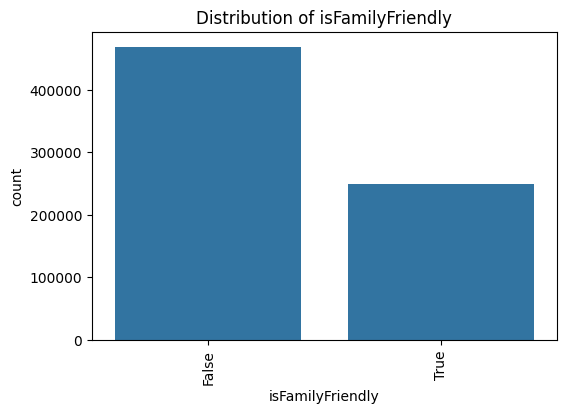

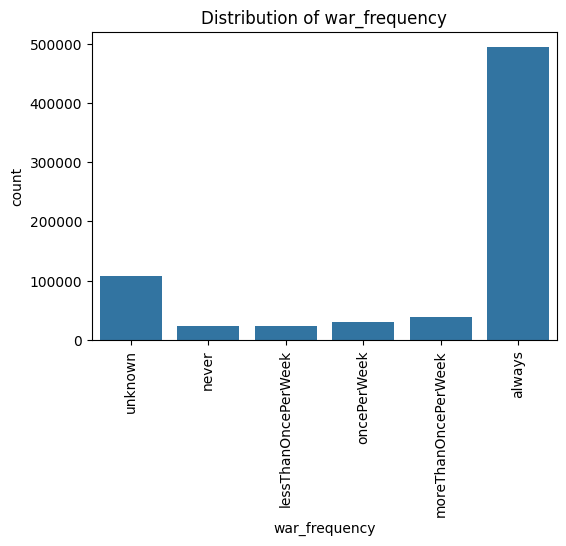

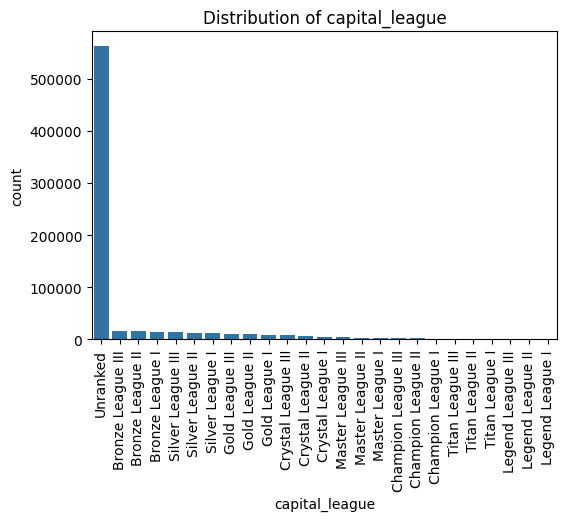

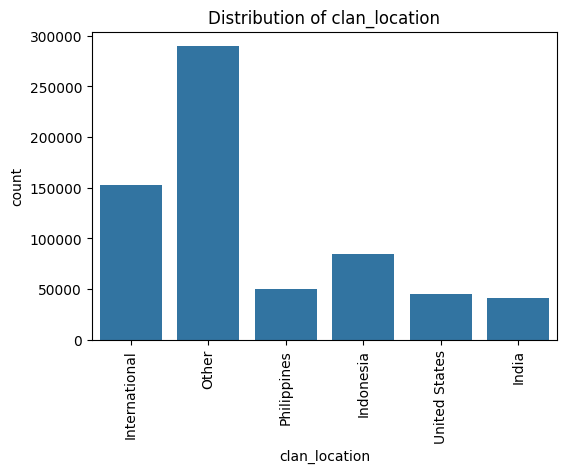

In [24]:
categorical_cols = ['clan_type', 'isFamilyFriendly', 'war_frequency', 'capital_league', 'clan_location']

# Plot counts of each feature's categorical values
for col in categorical_cols:
  plot_dist(cleaned_coc_df, col, cat=True)

Observations:


*   More clans set 'always' as their war frequency than expected. Clans that set 'always' as their war frequency might attract players that take wars more seriously and actually participate.
*   The vast majority of clans are 'Unranked' in capital league. This is likely because capital league is a feature that is relatively new, and thus clans may not have had the chance to advance far in the leagues yet. However, since capital league is directly related to events called "raids," which are relatively similar to wars, clans that are in better capital leagues may also take war more seriously and perform better.
*   The vast majority of players live in the Philippines, Indonesia, the United States, India, and something labeled "International." Every other country put into "Other" accounts for less than 3% of the total number of clans. This will be helpful in encoding this category, since one-hot encoding all the countries would drastically increase our dimensionality. Since there are less than 10 countries that appear very often in our dataset, we can just one-hot encode the most frequent ones and group the rest in "Other."


Again, we will investigate the clans that have perfect winrates.

In [25]:
# Re-copy the perfect winrate clans in order to get the updated categorical columns
perfect_win_df = cleaned_coc_df[cleaned_coc_df['win_percentage'] == 100]

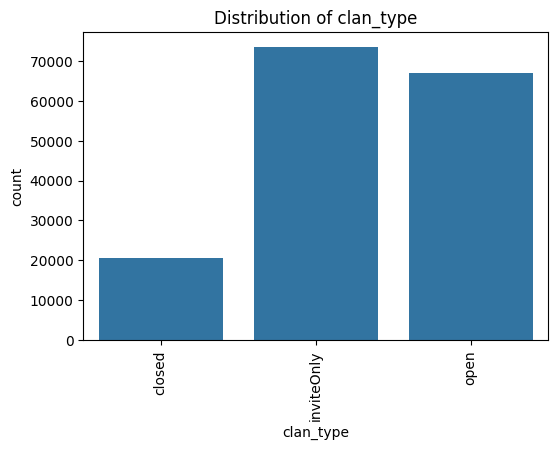

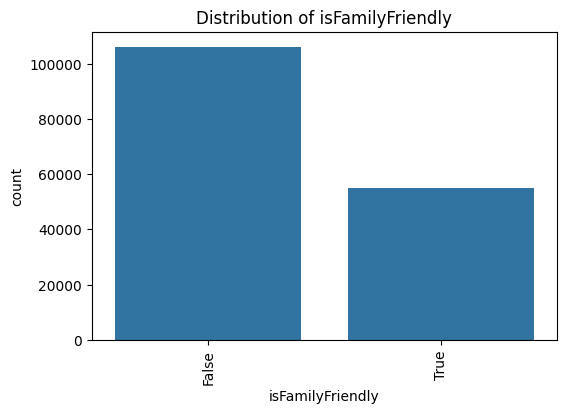

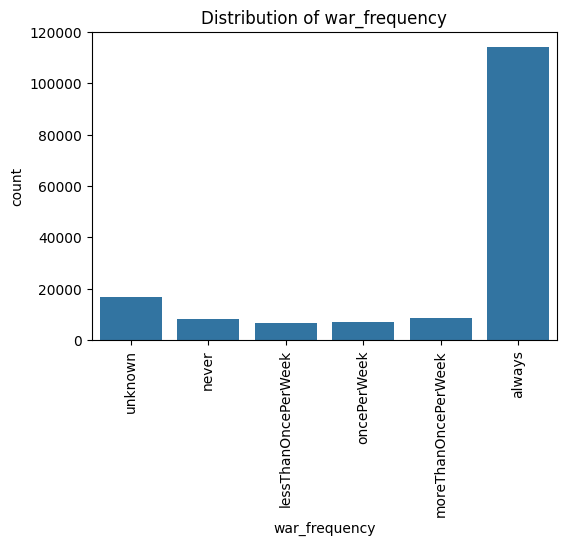

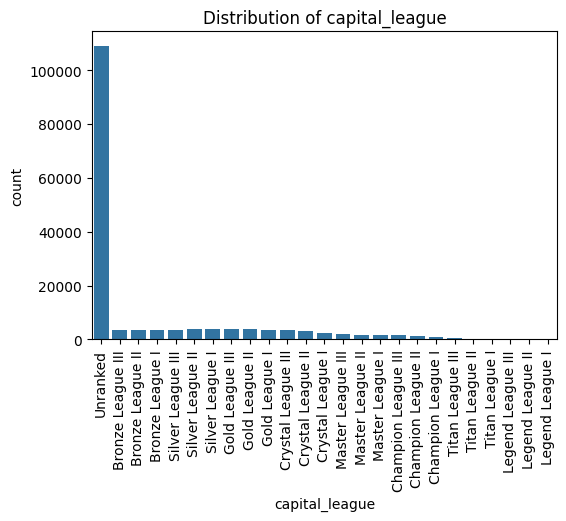

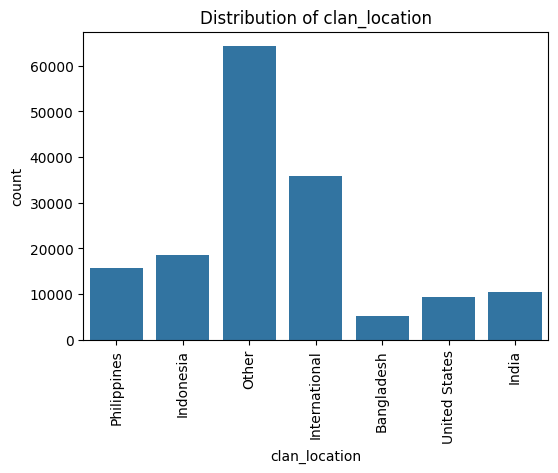

In [26]:
# Plot counts of each feature's categorical values
for col in categorical_cols:
  plot_dist(perfect_win_df, col, cat=True)

Observations:
*   There are not many differences between the distribution of the perfect winrate clans and those that don't have perfect winrates.
*   In the distribution of perfect winrate clans, the proportion of clans that are invite-only is higher than those that are open, which is different from the non-perfect winrate clans. This suggests that clans that are more exclusive may have higher winrates, probably because they don't accept bad players.
*   Bangladesh makes up over 3% of the perfect winrate clans, while they make up less than 3% of the non-perfect winrate clans. This suggests that players from Bangladesh may be slightly better for whatever reason.

## 3.2 Numerical Feature Correlations

We will plot a heatmap of the correlations of different numerical features.

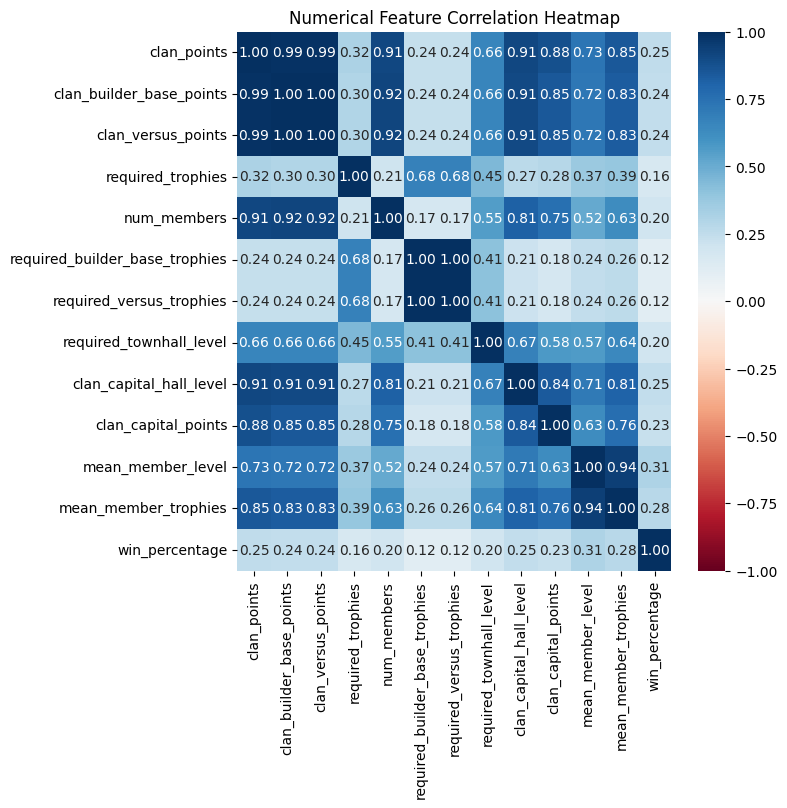

In [27]:
plt.figure(figsize=(7,7))
fig = sns.heatmap(data = cleaned_coc_df[numerical_cols].corr(),
                  cmap = 'RdBu',
                  vmin = -1,
                  vmax = 1,
                  annot = True,
                  fmt=".2f")
plt.title('Numerical Feature Correlation Heatmap')
plt.show()

Observations:


*   All of the features are positively correlated. This makes sense because as clans tend to get "better", metrics like the required trophies or member levels all should generally increase.
*   All of the features are weakly correlated with `win_percentage`. We may have to do some extra feature engineering to have a better performance with predicting the `win_percentage`.
*   Some features are extremely strongly correlated with each other, like `clan_points`, `clan_builder_base_points`, and `clan_versus_points`. We may need to drop some features later to prevent multicollinearity.


## 3.3 Text Data EDA

First, we will visualize the distribution of text lengths in the clan names and clan descriptions.

In [28]:
# Create a dataframe of just the textual features and win_percenatge
text_df = cleaned_coc_df[['clan_name', 'clan_description', 'win_percentage']].copy()

In [29]:
# Extract the text lengths from both textual features
text_df['clan_name_length'] = text_df['clan_name'].str.len()
text_df['clan_description_length'] = text_df['clan_description'].str.len()

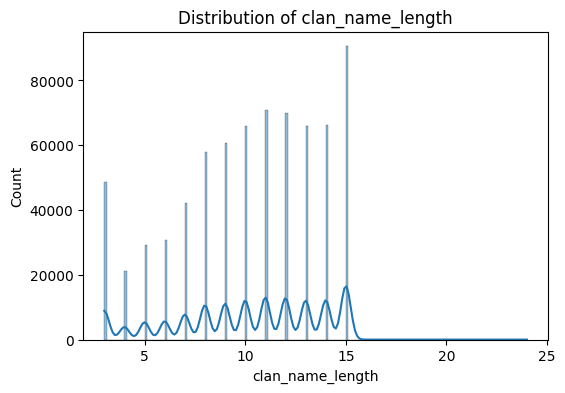

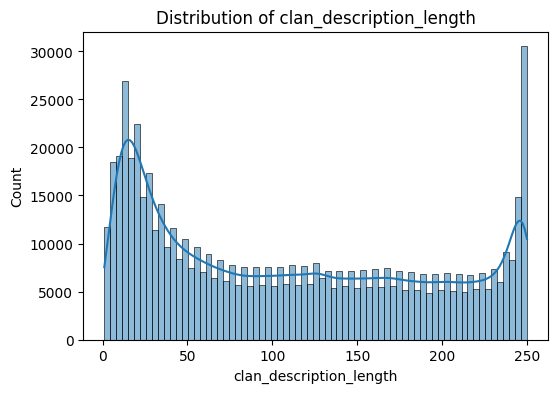

In [30]:
# Plotting the distribution of these text lengths
for col in ['clan_name_length', 'clan_description_length']:
  plot_dist(text_df, col, cat=False)

Now that we've extracted the length of these text features, we will see if there is any relationship between them and win rates by creating bins with equal-sized number of clans.

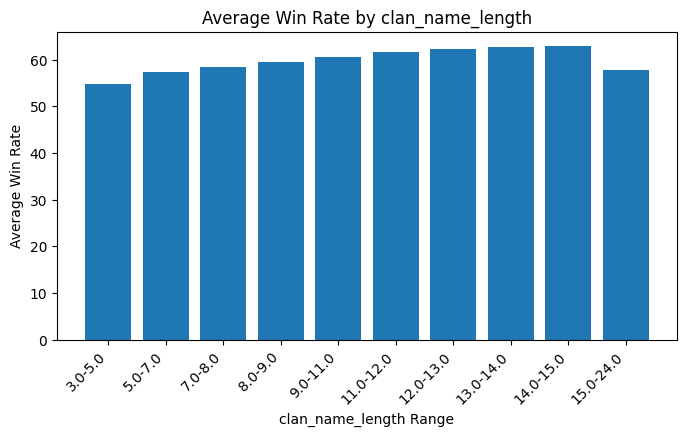

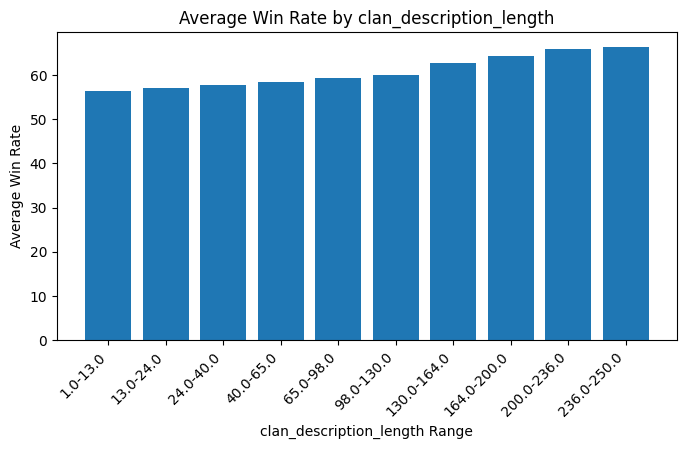

In [31]:
for col in ['clan_name_length', 'clan_description_length']:
  # Create 10 bins
  text_df[f'{col}_range'] = pd.qcut(text_df[col], q=10, labels=False)

  # Calculate average win rate per bin
  win_rates_by_length = text_df.groupby(f'{col}_range')['win_percentage'].agg(['mean']).reset_index()

  # Create labels for the bins
  bin_edges = pd.qcut(text_df[col], q=10, retbins=True)[1]
  win_rates_by_length[f'{col}_range_label'] = [
      f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(len(bin_edges)-1)
  ]

  # Plot a bar chart
  plt.figure(figsize=(8, 4))
  bars = plt.bar(win_rates_by_length[f'{col}_range_label'], win_rates_by_length['mean'])
  plt.title(f'Average Win Rate by {col}')
  plt.xlabel(f'{col} Range')
  plt.ylabel('Average Win Rate')
  plt.xticks(rotation=45, ha='right')

There seems to be a positive, linear trend between `clan_description_length` and `win_percentage`. Adding `clan_description_length` as a feature later may help the model.

We will now explore if certain manually-determined keywords are linked towards better war performance.

In [32]:
# function that takes in text and counts how many keywords occur in the text
def get_keyword_count(keywords, text):
  if not isinstance(text, str):
    return 0

  total = 0
  for keyword in keywords:
    total += text.lower().count(keyword.lower())

  return total

We will explore "positive" words that may be linked with clans that take war more seriously, as well as "negative" words that may be linked with more casual clans. These words were just chosen by intuition on what might be linked to clan war success.

In [33]:
positive_keywords = ['competitive', 'active', 'serious', 'war', 'teamwork',
                     'pro', 'trophy', 'skill', 'donation', 'must participate']

# Calculate number of positive keywords in each description
text_df['positive_keywords'] = text_df['clan_description'].apply(
    lambda x: get_keyword_count(positive_keywords, x))

negative_keywords = ['casual', 'fun', 'no rules', 'no war',
                     'everyone is welcome', 'relaxed']

# Calculate number of negative keywords in each description
text_df['negative_keywords'] = text_df['clan_description'].apply(
    lambda x: get_keyword_count(negative_keywords, x))

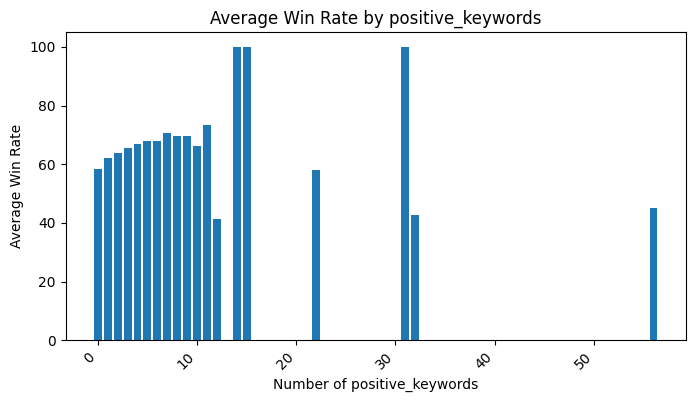

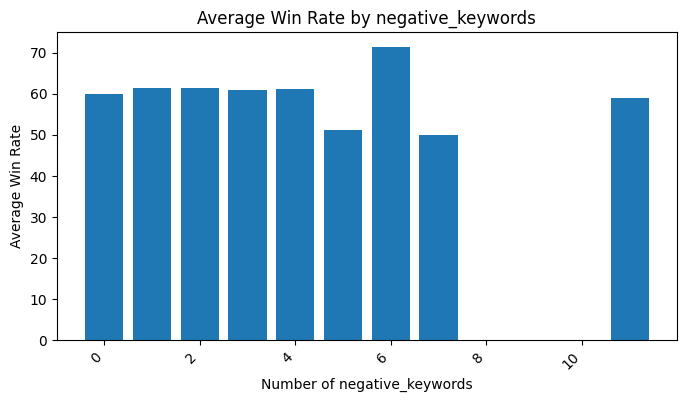

In [34]:
for col in ['positive_keywords', 'negative_keywords']:
  # Calculate average win rate per keyword length
  win_rates_by_length = text_df.groupby(col)['win_percentage'].agg(['mean']).reset_index()

  # Plot a bar chart
  plt.figure(figsize=(8, 4))
  bars = plt.bar(win_rates_by_length[col], win_rates_by_length['mean'])
  plt.title(f'Average Win Rate by {col}')
  plt.xlabel(f'Number of {col}')
  plt.ylabel('Average Win Rate')
  plt.xticks(rotation=45, ha='right')

There doesn't seem to be a clear correlation between these keywords and the winrate. It may be better to use embedding methods to extract the meaning of these descriptions instead.

## 3.4 Dealing with NaN and Dropping More Columns

Now that we have inspected our distributions, we will also deal with any NaN values that appear in our dataset properly. First, we need to get an understanding of what columns have null values and how many there are.

In [35]:
for col in cleaned_coc_df.columns:
  na_count = cleaned_coc_df[col].isna().sum()
  if na_count:
    print(f'{col}: {na_count}')

clan_name: 6
clan_description: 94403
clan_location: 57730
capital_league: 265


Since there are only 6 rows that have null clan names, we can just drop those rows. A large amount of clans have null clan descriptions, but clan descriptions are allowed to be empty, and there are currently no empty clan descriptions in our dataset. We will fill null clan descriptions with empty strings. For clan locations, a large amount have null values and the distribution doesn't have a clear majority, so we will create a new category "Missing" for those. Finally, the vast majority of clans have an unranked capital league, so we will impute that as the value.

In [36]:
# Fill in null clan descriptions with empty strings
cleaned_coc_df['clan_description'] = cleaned_coc_df['clan_description'].fillna('')

# Create a missing category for clan location
cleaned_coc_df['clan_location'] = cleaned_coc_df['clan_location'].fillna('Missing')

# Convert clan_location to categorical type but without ordering (we did not
# do above in order to add Missing later)
cleaned_coc_df['clan_location'] = cleaned_coc_df['clan_location'].astype(
    pd.CategoricalDtype(ordered=False))

# Impute the capital league with the mode (unranked)
cleaned_coc_df['capital_league'] = cleaned_coc_df['capital_league'].fillna(cleaned_coc_df['capital_league'].mode()[0])

# Drop the remaining rows with null clan names
cleaned_coc_df.dropna(inplace=True)

print(f"Number of remaining entries: {len(cleaned_coc_df)}")

Number of remaining entries: 719765


We will also drop numerical columns that are very strongly correlated with each other, in order to prevent collinearity in our model.

In [37]:
cleaned_coc_df.drop(columns=['clan_builder_base_points', 'clan_versus_points',
                             'num_members', 'clan_capital_hall_level',
                             'clan_capital_points', 'mean_member_trophies',
                             'required_versus_trophies'], inplace=True)

# Part 4: Feature Engineering and Dataset Creation

## 4.1 Numerical Features

As discovered during our text data EDA, adding `clan_description_length` may provide some useful information for our model.

In [38]:
cleaned_coc_df['clan_description_length'] = cleaned_coc_df['clan_description'].str.len()

First, we will split up the dataset into the features and targets.

In [39]:
# Extract features
coc_features = cleaned_coc_df.drop('win_percentage', axis=1)
# Extract targets
coc_targets = cleaned_coc_df['win_percentage']

Next, we will encode our categorical features. Unordered categorical data will be one-hot encoded, and ordered categorical data will be ordinal encoded. For clan location, we will one-hot encode only the top 10 locations with the highest frequencies. Using one hot encoding on all of the locations would result in an extremely high dimensionality, so countries that appear much less often will just be grouped into some "Other" category.

Note that when we one-hot encode our variables, we will set drop_first=True in order to prevent multicollinearity from one variable being used to determine the other.

In [40]:
def top_n_encode(df, column, n=10, other_label='Other'):
  categorical = False
  if df[column].dtype.name == 'category':
    categorical = True
    df[column] = df[column].astype('object') # Cast to object in case it's categorical

  # Get counts
  value_counts = df[column].value_counts()

  # Get top n categories
  top_categories = value_counts.nlargest(n).index.tolist()

  # Replace column with encoded column
  df[column] = df[column].apply(
      lambda x: x if x in top_categories else other_label
  )

  # Convert back to categorical
  if categorical:
    df[column] = df[column].astype(pd.CategoricalDtype(ordered=False))

In [41]:
# Top-10 encode clan location
top_n_encode(coc_features, 'clan_location')

# One hot encode unordered categorical features
one_hot_coc_features = pd.get_dummies(coc_features,
                                      columns=['clan_type', 'clan_location'],
                                      drop_first=True)

# Ordinal encode the ordered categorical features we had before
final_coc_features = one_hot_coc_features
for col in ['war_frequency', 'capital_league']:
  final_coc_features[col] = final_coc_features[col].cat.codes

In [42]:
final_coc_features.head()

,clan_name,clan_description,isFamilyFriendly,clan_points,required_trophies,war_frequency,required_builder_base_trophies,required_townhall_level,capital_league,mean_member_level,...,clan_location_France,clan_location_Germany,clan_location_India,clan_location_Indonesia,clan_location_International,clan_location_Missing,clan_location_Other,clan_location_Philippines,clan_location_Türkiye,clan_location_United States
0,KOJIS' CLAN,STRATEGY IS MUST...RESPECT THE OTHERS...FORGIV...,True,6887,800,4,1000,1,0,83,...,False,False,False,False,True,False,False,False,False,False
5,1worey200,,True,611,0,0,0,1,0,22,...,False,False,False,False,False,False,True,False,False,False
12,Raxus 2.0,"REGLAS: HACER SUS DOS ATAQUES EN GUERRA, REALI...",True,414,1000,5,600,9,0,40,...,False,False,False,False,False,False,True,False,False,False
15,PNOY CIVIL ENGR,SOON,True,1155,0,0,0,1,0,165,...,False,False,False,False,False,False,False,True,False,False
23,"""Darah Muda""",berdiri teguh bersama..1000 donate dpat elder....,True,955,0,5,0,1,0,97,...,False,False,False,False,False,False,True,False,False,False


## 4.2 Text Vectorization

Now, we have to handle our text features, which are `clan_name` and `clan_description`. We will encode our text features use TF-IDF vectorization. The reason we choose this over complex embeddings is because our dataset size is large, and the semantic meaning of clan names and clan descriptions is likely less important than simply the presence of certain keywords.

Before vectorization, we will clean our text a bit. This includes getting rid of numbers, special characters, and other things that won't really help us understand how the model is working.

In [43]:
def clean_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove special characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Clean our text features
final_coc_features['clan_name'] = final_coc_features['clan_name'].apply(clean_text)
final_coc_features['clan_description'] = final_coc_features['clan_description'].apply(clean_text)

Split our dataset before vectorization in order to avoid data leakage.

In [44]:
# Split the dataset into 80% training 20% test with a set seed
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(final_coc_features,
                                                    coc_targets,
                                                    test_size=.2,
                                                    random_state=SEED,
                                                    shuffle=True)

Delete unneeded DataFrames to save RAM.

In [45]:
del final_coc_features
del coc_targets
del low_participation_df

# Call garbage collector explicitly
gc.collect()

172176

We will vectorize the two text columns separately and also prevent data leakage. We will name the columns of the vectorization based on what terms they represent.

In [46]:
# Create separate vectorizers for each column
vectorizer1 = TfidfVectorizer(stop_words='english', min_df=.03, max_df=.4)
vectorizer2 = TfidfVectorizer(stop_words='english', min_df=.03, max_df=.4)

# Vectorize each column separately
X_train_tfidf1 = vectorizer1.fit_transform(X_train['clan_name']).toarray()
X_train_tfidf2 = vectorizer2.fit_transform(X_train['clan_description']).toarray()

X_test_tfidf1 = vectorizer1.transform(X_test['clan_name']).toarray()
X_test_tfidf2 = vectorizer2.transform(X_test['clan_description']).toarray()

# Get feature names for clan name vectorizer
clan_name_features = vectorizer1.get_feature_names_out()

# Get feature names for clan description vectorizer
clan_description_features = vectorizer2.get_feature_names_out()

# Create mappings from indices to terms to name the columns appropriately
clan_name_feature_dict = {i: term for i, term in enumerate(clan_name_features)}
clan_description_feature_dict = {i: term for i, term in enumerate(clan_description_features)}

# Convert embeddings into DataFrames
X_train_tfidf1_df = pd.DataFrame(X_train_tfidf1, columns=[f'name_has_{clan_name_feature_dict[i]}' for i in range(X_train_tfidf1.shape[1])])
X_train_tfidf2_df = pd.DataFrame(X_train_tfidf2, columns=[f'desc_has_{clan_description_feature_dict[i]}' for i in range(X_train_tfidf2.shape[1])])

X_test_tfidf1_df = pd.DataFrame(X_test_tfidf1, columns=[f'name_has_{clan_name_feature_dict[i]}' for i in range(X_test_tfidf1.shape[1])])
X_test_tfidf2_df = pd.DataFrame(X_test_tfidf2, columns=[f'desc_has_{clan_description_feature_dict[i]}' for i in range(X_test_tfidf2.shape[1])])

# Align indices before concatenating
X_train_tfidf1_df.index = X_train.index
X_train_tfidf2_df.index = X_train.index
X_test_tfidf1_df.index = X_test.index
X_test_tfidf2_df.index = X_test.index

# Concatenate TF-IDF DataFrame to original DataFrame
X_train_combined = pd.concat([X_train_tfidf1_df, X_train_tfidf2_df,
                              X_train.drop(columns=['clan_name', 'clan_description'])], axis=1)

X_test_combined = pd.concat([X_test_tfidf1_df, X_test_tfidf2_df,
                              X_test.drop(columns=['clan_name', 'clan_description'])], axis=1)

Delete more dataframes to save memory.

In [47]:
del X_train_tfidf1_df
del X_train_tfidf2_df
del X_train_tfidf1
del X_train_tfidf2

# Call garbage collector explicitly
gc.collect()

21630

## 4.3 Scaling

We will scale the numerical columns as well to prevent bias from large ranges.

In [48]:
columns_to_scale = [
    'clan_points',
    'required_trophies',
    'war_frequency',
    'required_builder_base_trophies',
    'required_townhall_level',
    'capital_league',
    'mean_member_level',
    'clan_description_length',
]
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform on training set
X_train_combined[columns_to_scale] = scaler.fit_transform(X_train_combined[columns_to_scale])

# Just transform the test set to avoid data leakage
X_test_combined[columns_to_scale] = scaler.transform(X_test_combined[columns_to_scale])

In [49]:
X_train_combined.head()

,name_has_clan,desc_has_active,desc_has_attack,desc_has_clan,desc_has_di,desc_has_donate,desc_has_dont,desc_has_elder,desc_has_en,desc_has_guerra,...,clan_location_France,clan_location_Germany,clan_location_India,clan_location_Indonesia,clan_location_International,clan_location_Missing,clan_location_Other,clan_location_Philippines,clan_location_Türkiye,clan_location_United States
2221138,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
2681264,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
2612065,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False
132715,0.0,0.000000,0.0,0.867449,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
138017,0.0,0.472759,0.0,0.627915,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False


Note that we do not choose to use PCA in this modeling process. The dimensionality of our features is not very high, and we want to maintain interpretability. Since PCA engineers features that are linear combinations of our original features, this will reduce our interpretability.

# Part 5: Modeling

## 5.1 Baseline: Linear Regression

First, we will fit a very simple linear regression model onto the dataset. This is an extremely interpretable, lightweight model for our task.

In [50]:
# Initialize the linear regression model
reg = LinearRegression()

# Fit the model on our scaled data
reg.fit(X_train_combined, y_train)

# Calculate the R^2 score of the training data
train_score = reg.score(X_train_combined, y_train)

print(f'R^2 Training Data: {train_score}')

R^2 Training Data: 0.1547486647978068


In [51]:
# Calculate the R^2 score of the test data
test_score = reg.score(X_test_combined, y_test)

print(f'R^2 Testing Data: {test_score}')

R^2 Testing Data: 0.1572731194270195


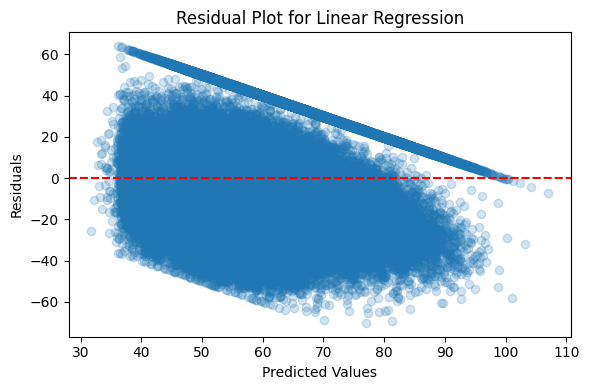

In [52]:
y_pred = reg.predict(X_test_combined)
residuals = y_test - y_pred

# Create the residual plot
plt.figure(figsize=(6, 4))
sns.residplot(x=y_pred, y=residuals, scatter_kws={'alpha': 0.2})

plt.title('Residual Plot for Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

Observations:


*   Clearly, the baseline model is not performing very well. This may be because the relationship between our features and the target is non-linear, and we must do further feature engineering or use non-linear models. It could also demonstrate that the relationships between our features and our target are not very significant, which is supported so far by the very low correlations between each feature and the `win_percentage` when we conducted EDA.
*   The very low difference between the training dataset and the testing data could also indicate that our model is simply underfitting.
*   From the residual plot, it is clear that our model is performing very badly on the clans that have a perfect winrate. The model may have trouble differentiating between perfect winrate clans and non-perfect winrate clans, especially because this is a linear model.


Since we focused on making our model interpretable, we will also look at feature importances by inspecting the coefficients of our model. Coefficients with higher absolute values will be more important in our model.

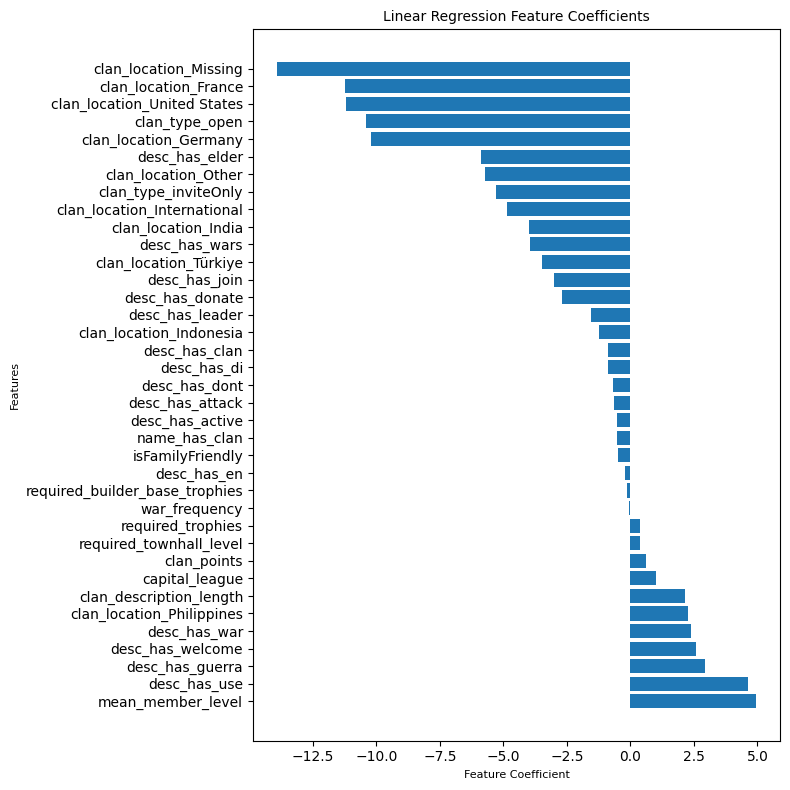

In [53]:
reg_coefficients = pd.DataFrame({
    'feature': X_train_combined.columns,
    'coefficient': reg.coef_
})

# Sort by absolute value of coefficients in descending order
reg_coefficients.sort_values('coefficient',
                             ascending=False,
                             inplace=True)

plt.figure(figsize=(8, 8))

# Create a horizontal bar plot of all features
plt.barh(reg_coefficients['feature'], reg_coefficients['coefficient'])

plt.title('Linear Regression Feature Coefficients', fontsize=10)
plt.xlabel('Feature Coefficient', fontsize=8)
plt.ylabel('Features', fontsize=8)
plt.tight_layout()
plt.show()

Observations:
*   On average, having a missing location decreases the win percentage by around 13%. Since clan locations do not have to be set by the clan, one possible explanation is that clans without locations specified leads to people who speak different languages joining the same clan, leading to bad communication and lower war performance.
*   Having a clan location of the United States or France also decreases the win percentage, on average. This could just be because the gaming communities in these countries for Clash of Clans is more casual, compared to somewhere like the Philippines, which has a positive feature coefficient.
*   Interestingly, having a higher `war_frequency`, `required_trophies`, and `required_townhall_level` on average has a very small impact on the win percentage, demonstrated by their low feature coefficients. This could be related to skill-based matchmaking, since clans that have better metrics here might get matched up against other clans with similar metrics, balancing out the winrates.
*   Having words like "war" and "guerra" (which means war in Spanish), leads to higher win percentages on average. These words may attract players who are more serious about war.


## 5.2 Random Forest Regression

Next, we choose to train a Random Forest Regressor. There are several reasons for this model choice. The first is that because Random Forests can be trained in parallel, which is helpful for our large amount of data. The second is that Random Forests provide interpretability. The third reason is that they can also approximate non-linear relationships, which is an improvement upon our baseline model. Being able to model non-linear relationships may help us find more complex trends and fit better to the data.

We will first attempt to train a model without hyperparameter tuning.



In [54]:
# Initialize a Random Forest Regressor model
rfreg = RandomForestRegressor(n_jobs=-1)
rfreg.fit(X_train_combined, y_train)

# Calculate the R^2 score of the training data
train_score = rfreg.score(X_train_combined, y_train)

print(f'R^2 Training Data: {train_score}')

# Calculate the R^2 score of the test data
test_score = rfreg.score(X_test_combined, y_test)

print(f'R^2 Testing Data: {test_score}')

R^2 Training Data: 0.8802530738129196
R^2 Testing Data: 0.14488997461861652


Clearly, our initial Random Forest Regressor model is extremely overfit to the training data, since the R^2 score is much higher on the training data than the testing data.

We will use Randomized Search in order to tune our hyperparameters. This is because we have a few different hyperparameters that we want to tune, and exploring every single possibility (such as in GridSearch) with the amount of data that we have would take a long time.

Our goal is to reduce overfitting, so the hyperparameters we will tune are n_estimators, max_depth, and max_features. We will search lower numbers for n_estimators to allow for less trees and reduce overfitting, as well as smaller max_depth options to reduce how deep the tree goes. Similarly, max_features also has smaller values like .5 or "sqrt", which limits how many features we look at when choosing a split, which prevents overfitting.


In [55]:
# Initialize a Random Forest Regressor model
rfreg = RandomForestRegressor()

# Create parameters for our Randomized Search
params = {
  'n_estimators': [50, 100, 200],
  'max_depth': [None, 3, 5, 15],
  'max_features': [0.5, 1.0, 'sqrt'],
}

# Create a Random Search object
rfreg_random_search = RandomizedSearchCV(
  rfreg,
  param_distributions=params,
  n_iter=5,
  scoring='r2',
  cv=5,
  random_state=42,
  n_jobs=-1
)

# Fit the search object to the training data
rfreg_random_search.fit(X_train_combined, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 15],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='r2')

In [56]:
 # Get the best found model
rfreg_best = rfreg_random_search.best_estimator_

# Calculate the R^2 score of the training data
train_score = rfreg_best.score(X_train_combined, y_train)

print(f'R^2 Training Data: {train_score}')

# Calculate the R^2 score of the test data
test_score = rfreg_best.score(X_test_combined, y_test)

print(f'R^2 Testing Data: {test_score}')

R^2 Training Data: 0.23155108939200952
R^2 Testing Data: 0.17569874760038895


In [57]:
print(rfreg_random_search.best_params_)

{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 15}


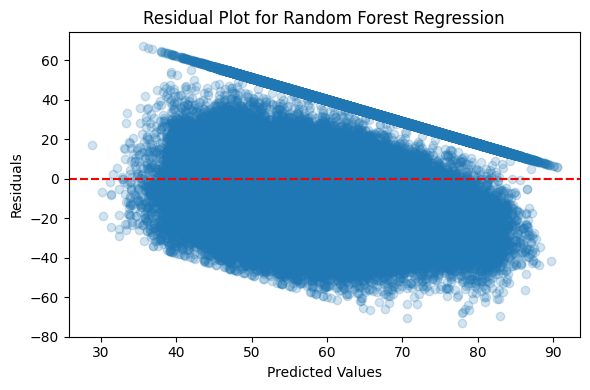

In [58]:
y_pred = rfreg_best.predict(X_test_combined)
residuals = y_test - y_pred

# Create the residual plot
plt.figure(figsize=(6, 4))
sns.residplot(x=y_pred, y=residuals, scatter_kws={'alpha': 0.2})

plt.title('Residual Plot for Random Forest Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

Observations:
*   The Random Forest Regression, while performing slightly better than linear regression, still performs rather poorly. Although there is now a slight difference betweeen the performance on the training and test data and we have reduced our overfitting, the model is still not fitting that well.
*   The model, similarly to linear regression, struggles with predicting the clans with perfect winrates. It may simply be that the features we have in our dataset do not give us enough information to predict the win percentage very well.

Now, we will inspect the feature importances from our Random Forest model to interpret what features contribute the most to our regression.

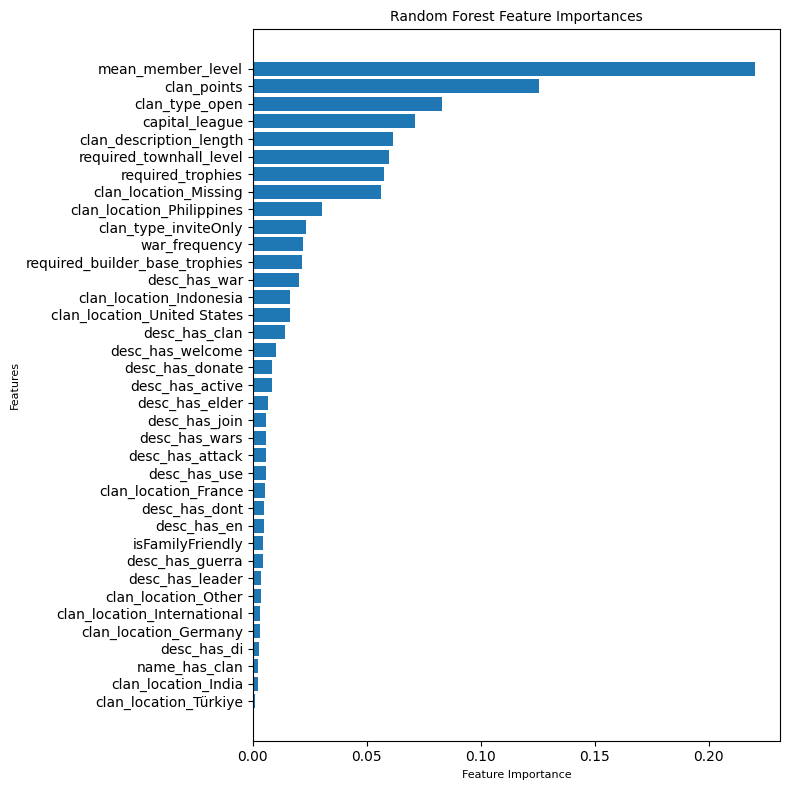

In [59]:
# Get feature importances
feature_importances = rfreg_best.feature_importances_

# Get names from our training DataFrame
feature_names = X_train_combined.columns.tolist()

# Get indices in sorted order
indices = np.argsort(feature_importances)

plt.figure(figsize=(8, 8))

# Create a horizontal bar plot of all features
plt.barh(range(len(feature_importances)), feature_importances[indices])

# Change y-axis so that it displays feature names
plt.yticks(range(len(feature_importances)), [feature_names[i] for i in indices])

plt.title('Random Forest Feature Importances', fontsize=10)
plt.xlabel('Feature Importance', fontsize=8)
plt.ylabel('Features', fontsize=8)
plt.tight_layout()
plt.show()

Observations:
*   Unlike the linear regression model, the Random Forest Regression model seems to place more feature importance on numerical features that are related to members' skill levels, such as `clan_points` (related to the trophies a member has), `required_townhall_level`, and `required_trophies`.
*   While the `clan_description_length` seems to be a pretty important feature, the actual content of the description does not seem to be important. This is demonstrated through the low feature importances of features like `desc_has_leader` or `desc_has_attack`.

## 5.3 Gradient Boosted Regression

To address the poor fits of both the linear regression model and our Random Forest regression model, we will now try a Gradient Boosted regression model, specifically XGBoost. The sequential trees will focus more on incorrect predictions, hopefully leading to less underfitting and better performance on the clans with perfect winrates.

We will use the [Scikit-Learn Wrapper](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) interface for XGBoost.

We will first try a naive model without hyperparameter tuning.

In [60]:
# Initialize a Random Forest Regressor model
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train_combined, y_train)

# Calculate the R^2 score of the training data
train_score = xgbr.score(X_train_combined, y_train)

print(f'R^2 Training Data: {train_score}')

# Calculate the R^2 score of the test data
test_score = xgbr.score(X_test_combined, y_test)

print(f'R^2 Testing Data: {test_score}')

R^2 Training Data: 0.21323815855082373
R^2 Testing Data: 0.18726581450748503


Now, we will tune similar hyperparameters as we did for our Random Forest Regressor, leaning towards values that will reduce underfitting (such as high n_estimators, no max_depth, lower learning rates, etc.). A few parameters like min_child_weight, subsample, and colsample_bytree will still be tuned a bit just in case our model overfits a little when changing the former parameters.

In [61]:
# Initialize a Gradient Boosted Regressor model
xgbr = xgb.XGBRegressor()

# Create parameters for our Randomized Search
params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 3, 6, 9, 15],
    'learning_rate': [0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Create a Random Search object
xgbr_random_search = RandomizedSearchCV(
    xgbr,
    param_distributions=params,
    n_iter=20,
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the search object to the training data
xgbr_random_search.fit(X_train_combined, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.05, 0.1, 0.3],
                                        'max_depth': [None, 3, 6, 9, 15],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2')

In [62]:
# Get the best found model
xgbr_best = xgbr_random_search.best_estimator_

# Calculate the R^2 score of the training data
train_score = xgbr_best.score(X_train_combined, y_train)

print(f'R^2 Training Data: {train_score}')

# Calculate the R^2 score of the test data
test_score = xgbr_best.score(X_test_combined, y_test)

print(f'R^2 Testing Data: {test_score}')

R^2 Training Data: 0.2121158972895455
R^2 Testing Data: 0.18989773288961465


In [63]:
# Print the best parameters
print(xgbr_random_search.best_params_)

{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


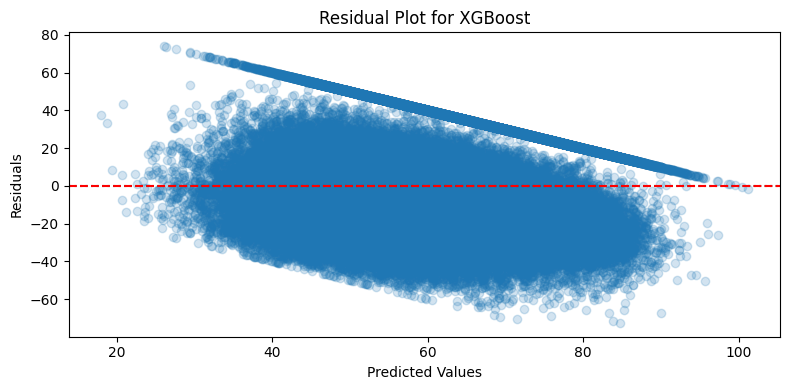

In [64]:
y_pred = xgbr_best.predict(X_test_combined)
residuals = y_test - y_pred

# Create the residual plot
plt.figure(figsize=(8, 4))
sns.residplot(x=y_pred, y=residuals, scatter_kws={'alpha': 0.2})

plt.title('Residual Plot for XGBoost')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

Observations:
*   The XGBoost Regression performs similarly to the linear regression and Random Forest Regression models.
*   Even though XGBoost weighs incorrectly predicted results higher, the model is still struggling with perfect winrate clans, just like the other models. It is likely that the features we have do not give enough information to differentiate between perfect and non-perfect winrate clans. This result is backed up by the low correlations each feature had with the win percentage, as well as the similar feature distributions of perfect and non-perfect winrate clans, discovered during our EDA.

Now, we will graph the feature importances from our XGBoost model to interpret what features are actually contributing to our predictions.

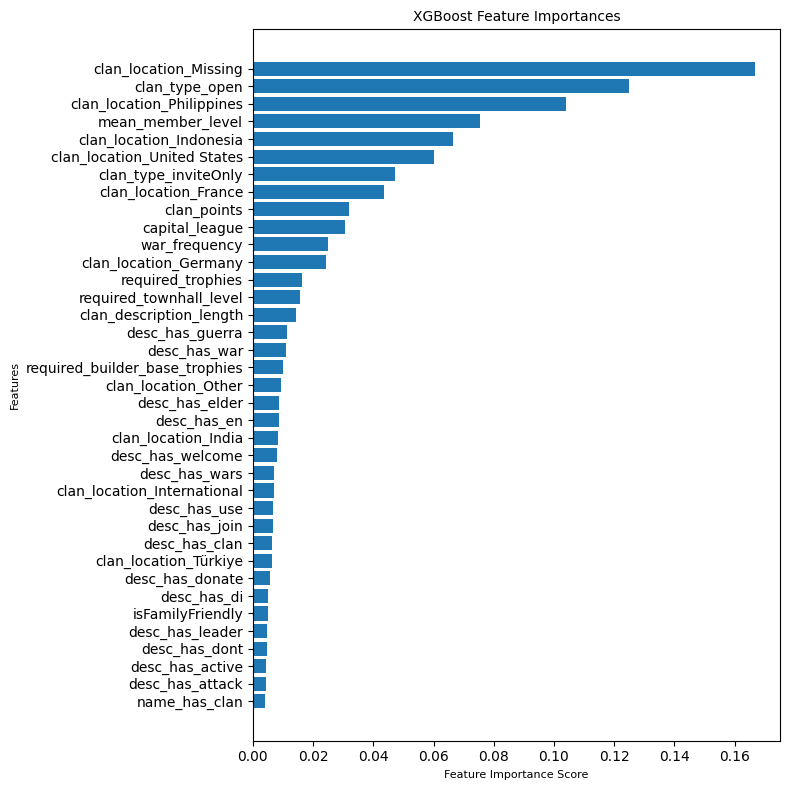

In [65]:
# Get feature importances
feature_importances = xgbr_best.feature_importances_

# Get names from our training DataFrame
feature_names = X_train_combined.columns.tolist()

# Get indices in sorted order
indices = np.argsort(feature_importances)

plt.figure(figsize=(8, 8))

# Create a horizontal bar plot of all features
plt.barh(range(len(feature_importances)), feature_importances[indices])

# Change y-axis so that it displays feature names
plt.yticks(range(len(feature_importances)), [feature_names[i] for i in indices])

plt.title('XGBoost Feature Importances', fontsize=10)
plt.xlabel('Feature Importance Score', fontsize=8)
plt.ylabel('Features', fontsize=8)
plt.tight_layout()
plt.show()

Observations:
*   Interestingly, the XGBoost model puts more emphasis on the location of the clans, demonstrated by the high feature importance of features like `clan_location_Missing`, `clan_location_Philippines`, etc. This differs from the Random Forest Model.
*   Again, the contents of the description are not very useful in predicting the win percentage.
*   It may be that the numerical features and the location features all have similar predictive power for the win percentage, which is why both the XGBoost model and the Random Forest model get similar performances using these features.

# Part 6: Conclusion

**Key takeaways:**

1.   Predicting the clan winrate was more complex than we initially thought. Even though we had many different features in our dataset, their relationships with the clan winrate were not very significant, leading to low model performances despite finetuning.
2.   The three models we attempted to use were a Linear Regression model, a Random Forest Regression model, and a Gradient Boosted Regression model. The Linear Regression model produced a test R^2 value of 0.157, our Random Forest Regression model produced 0.176, and our XGBoost model produced 0.190.
3. Even nonlinear, state-of-the-art models like XGBoost struggled to accurately predict clan winrates. From the residual plots of all of these models, every model struggled to accurately differentiate the perfect and non-perfect winrate clans, suggesting that our features were not sufficient in giving enough information to differentiate the two cases. This is corroborated by our EDA results when looking at the low feature correlations with the win percentage, as well as the similar feature distributions of perfect and non-perfect winrate clans. Logically, this also makes sense since clan wars are skill-based matchmaking, meaning that higher level clans (ex. with higher trophies) will get paired with similar clans, making it harder to predict winrates from these features.

**Results and Implications**
1. When looking at the feature importances of our three interpretable models, it seems that the contents of the clan description and clan name generally have very low significance with respect to the war winrate. Features like clan location and some metrics about the members' levels (such as townhall level) generally help in predicting winrate. However, the features used by each model varies, which again emphasizes the fact that most of the features have similarly weak predictive power for the winrate.
2. While our models performed rather poorly on our dataset, this information can still help inform people, such as clan owners or members looking for clans. The fact that the features we studied above have poor predictive power of the winrate shows that clan owners should not obsess too much on things like setting high trophy requirements or writing clan descriptions focused on war in order to perform better in war. Instead, qualitative attributes like the clan's culture and the communication within the clan likely matters more, which are features that were not evaluated in this model.
**Limitations and Future Modifications:**

1.   Our models were mainly limited by the weak relationships between our features and the target variable (winrate). Even using nonlinear and powerful models like XGBoost and Random Forest, we were only able to make minimal improvements over our baseline Linear Regression model.
2. One modification we could make in the future is to collect more data, such as donation behavior, clan chats, or more specific information about each member inside the clan (ex. the levels of different items in their base). This might give us more information for feature engineering and hopefully produce something that is more significant in predicting winrate. To do this, we would likely have to scrape our own data, as our dataset from kaggle was produced in 2023 and there weren't any other datasets from 2023 that we find to add more features for our modeling.
3. Another modification we could make in the future is to gain more insight in how the data was collected (such as by contacting the creator of the Kaggle dataset). It is unclear whether the large number of perfect winrate clans is real or whether its a data collection error, so investigating that would give us more information on how to model our data.
4. We could also use some more complex methods of encoding the clan description and clan name, such as using NLP methods like BERT encoders. While this would sacrifice some interpretability, it might give us better features to predict winrate.